In [8]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## For mean 

In [9]:
def get_scores(results, all_code=True):
    metrics = ("top1_acc", "top10_acc", "skip50_top1_acc", "skip50_top10_acc")
    modes = ("only_text", "only_code") if all_code else ("only_text", "only_python")
    # injection_coefficients = list(results["only_code"].keys())

    scores = {}
    for mode in modes:
        scores[mode] = {}
        for metric in metrics:
            scores[mode][metric] = {"avg": [], "rel": []}
            for ic_score in results[mode].values():
                if metric in ("top1_acc", "top10_acc"):
                    scores[mode][metric]["avg"].append(
                        100
                        * np.average(
                            ic_score[metric],
                            weights=ic_score["total_encoded_tokens"],
                        )
                    )
                else:
                    scores[mode][metric]["avg"].append(
                        100
                        * np.average(
                            ic_score[metric],
                            weights=ic_score["total_tokens_with_skip"],
                        )
                    )
            avg_scores = scores[mode][metric]["avg"]
            scores[mode][metric]["rel"] = [i / avg_scores[0] * 100 for i in avg_scores]

    return scores

In [10]:
# data used in paper for code
versions = ["9.01", "9.04", "9.05", "9.02", "9.06", "9.07", "9.03", "9.20"]
# # data used in paper for python
# versions = ["9.08", "9.09", "9.10", "9.11", "9.12", "9.13", "9.14", "9.21"]

results = []
for version in versions:
    with open(f"../results/coding/v_{version}.json", "r") as f:
        results.append(json.load(f))

for version, r in zip(versions, results):
    print(
        f"Version {version} note: {r['meta']['note']} layer: {r['meta']['layers']}"
    )  # neg_acts: {r['meta']['neg_acts']}")

Version 9.01 note: layer 0 500k test new ic distribution only code layer: [0]
Version 9.04 note: layer 5 500k test new ic distribution only code layer: [5]
Version 9.05 note: layer 10 500k test new ic distribution only code layer: [10]
Version 9.02 note: layer 15 500k test new ic distribution only code layer: [15]
Version 9.06 note: layer 20 500k test new ic distribution only code layer: [20]
Version 9.07 note: layer 25 500k test new ic distribution only code layer: [25]
Version 9.03 note: layer 30 500k test new ic distribution only code layer: [30]
Version 9.20 note: layer 15 500k test only code permuted layer: [15]


In [12]:
# vary all_code to False when plotting python
scores = [get_scores(res, all_code=True) for res in results]

labels = [
    "Layer 0",
    "Layer 5",
    "Layer 10",
    "Layer 15",
    "Layer 20",
    "Layer 25",
    "Layer 30",
    # "Layers 10 and 15",
    "Layer 15 permuted",
]

mode = "code"
# mode = "python"

## Inspect scores

In [5]:
# for score, res in zip(scores, results, strict=True):
#     print(f"\n\n--------------Layer: {res['meta']['layers'][0]}-------------")
#     a, b, c = score[f"only_{mode}"]["top1_acc"]["rel"], score[f"only_{mode}"]["top1_acc"]["rel"], res["meta"]["used_ics"]
#     for i, j, k in zip(a, b, c, strict=True):
#         print(f"text: {round(i, 2)}     code: {round(j, 2)}    ic: {round(k, 2)}")

## plot for only one metric

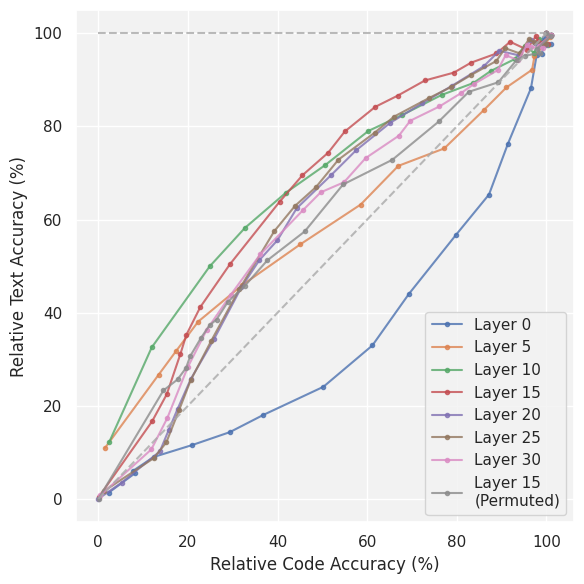

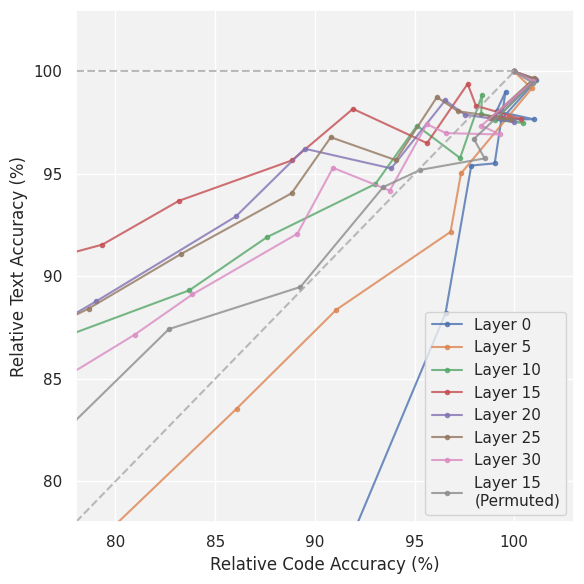

In [13]:
# create a seaborn style graph
sns.set_style("darkgrid", {"axes.facecolor": ".95"})
# sns.set_theme()


scale = 100
metric = "top1_acc"

for cropped in [False, True]:
    fig, ax = plt.subplots(figsize=(6, 6))

    for label, score in zip(labels, scores, strict=True):
        ax.plot(
            score[f"only_{mode}"][metric]["rel"],
            score["only_text"][metric]["rel"],
            marker=".",
            label=label.replace("permuted", "\n(Permuted)"),
            alpha=0.8,
        )

    ax.set_xlabel(f"Relative {mode.title()} Accuracy (%)")
    ax.set_ylabel("Relative Text Accuracy (%)")

    ax.plot([0, scale], [scale, scale], color="darkgray", linestyle="--", alpha=0.8)
    ax.plot([0, scale], [0, scale], color="darkgray", linestyle="--", alpha=0.8)

    if cropped:
        # Set the x and y axis limits
        ax.set_xlim([78, 103])
        ax.set_ylim([78, 103])

    plt.legend()
    fig.tight_layout()
    plt.show()